Memory-Optimized Spiking ViT for CIFAR-10 initialized on cuda
Memory-Optimized Temporal Spiking ViT for CIFAR-10
Device: cuda
GPU Memory: 17.1 GB
GPU Name: Tesla P100-PCIE-16GB

Optimized Configuration:
  Embed Dim: 384 (reduced)
  Blocks: 8 (reduced)
  Heads: 6 (reduced)
  Batch Size: 64 (reduced)
  Gradient Accumulation: 2 steps
  Gradient Checkpointing: True

Dataset: 50000 train, 10000 test samples
Model parameters: 11,883,712 (trainable: 11,883,712)

Starting Training...


/tmp/ipykernel_36/2901151619.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


  Batch 0/782 | Loss: 2.9189
  Batch 100/782 | Loss: 2.2809
  Batch 200/782 | Loss: 2.2824
  Batch 300/782 | Loss: 2.1194
  Batch 400/782 | Loss: 2.3172
  Batch 500/782 | Loss: 1.9426
  Batch 600/782 | Loss: 2.0530
  Batch 700/782 | Loss: 2.0013
Epoch [1/100] | Avg Loss: 2.2156
Epoch [1/100] | Test Acc: 0.3697 | Best: 0.0000 | LR: 2.00e-04
Checkpoint saved to ./cifar10_memory_optimized_best.pth
  → New best model saved! (acc: 0.3697)

  Batch 0/782 | Loss: 2.0968
  Batch 100/782 | Loss: 2.1619
  Batch 200/782 | Loss: 1.9183
  Batch 300/782 | Loss: 1.9656
  Batch 400/782 | Loss: 1.7538
  Batch 500/782 | Loss: 1.7430
  Batch 600/782 | Loss: 1.9832
  Batch 700/782 | Loss: 1.9504
Epoch [2/100] | Avg Loss: 1.9347
Epoch [2/100] | Test Acc: 0.4813 | Best: 0.3697 | LR: 2.00e-04
Checkpoint saved to ./cifar10_memory_optimized_best.pth
  → New best model saved! (acc: 0.4813)

  Batch 0/782 | Loss: 1.9843
  Batch 100/782 | Loss: 1.7233
  Batch 200/782 | Loss: 1.8171
  Batch 300/782 | Loss: 1.8014


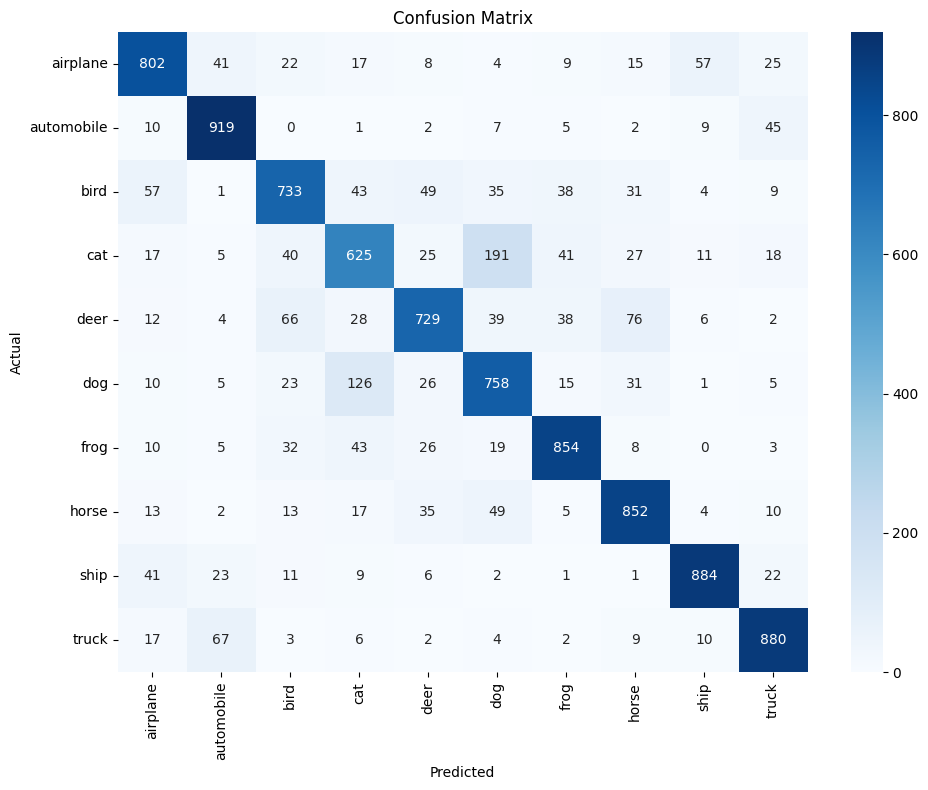


Generating model analysis visualizations...


/tmp/ipykernel_36/2901151619.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctx.save_for_backward(x, torch.tensor(temperature))


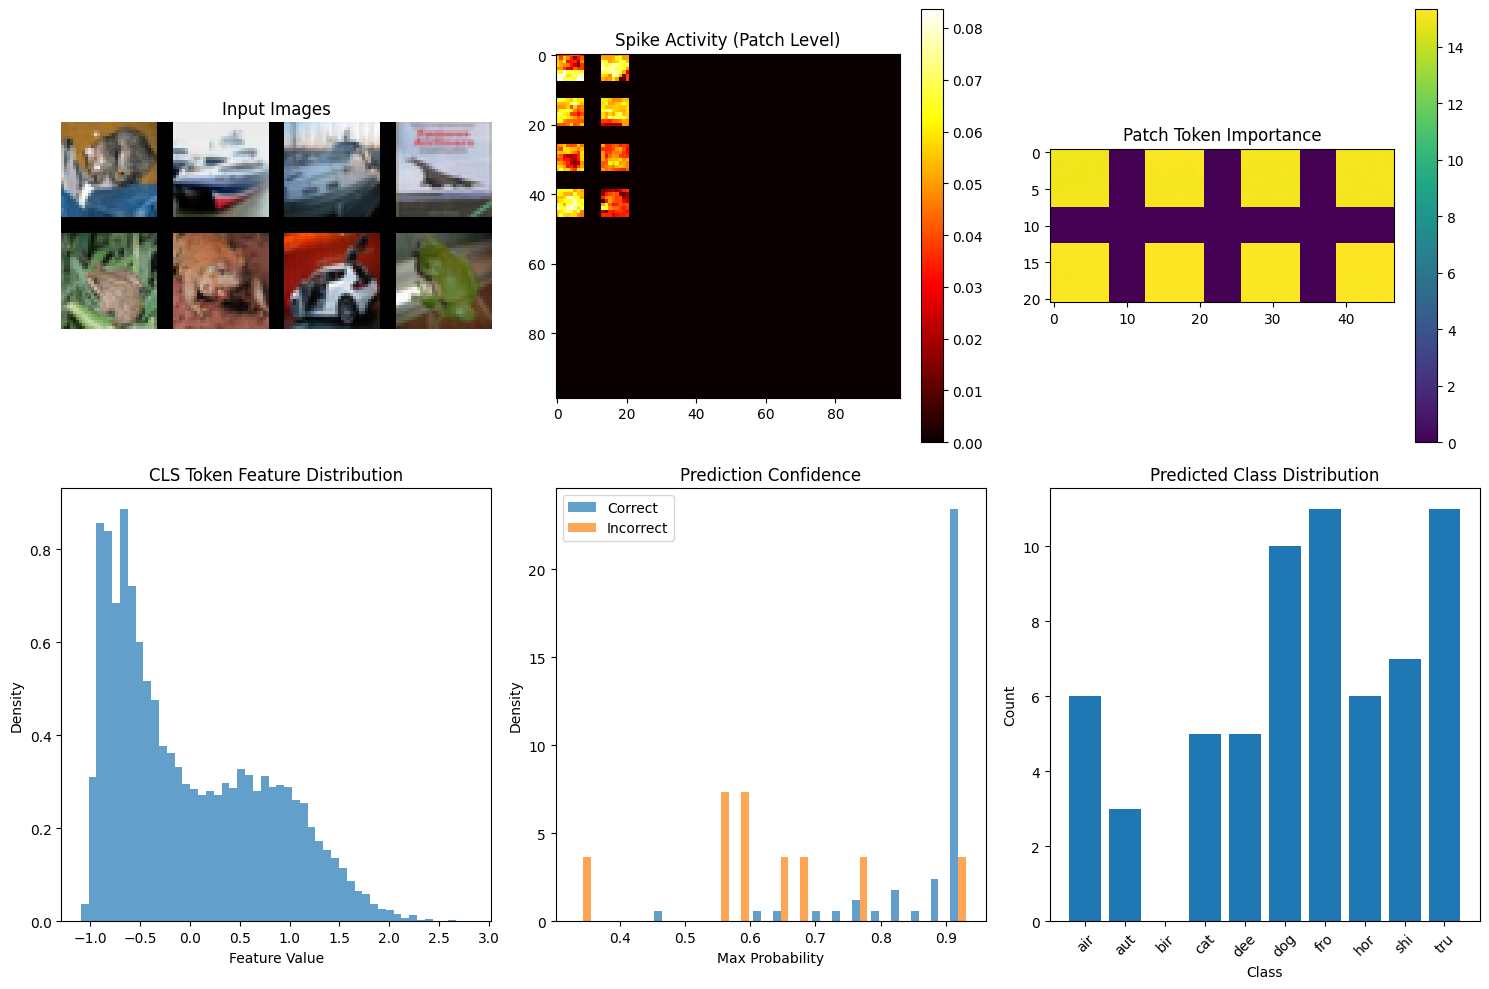

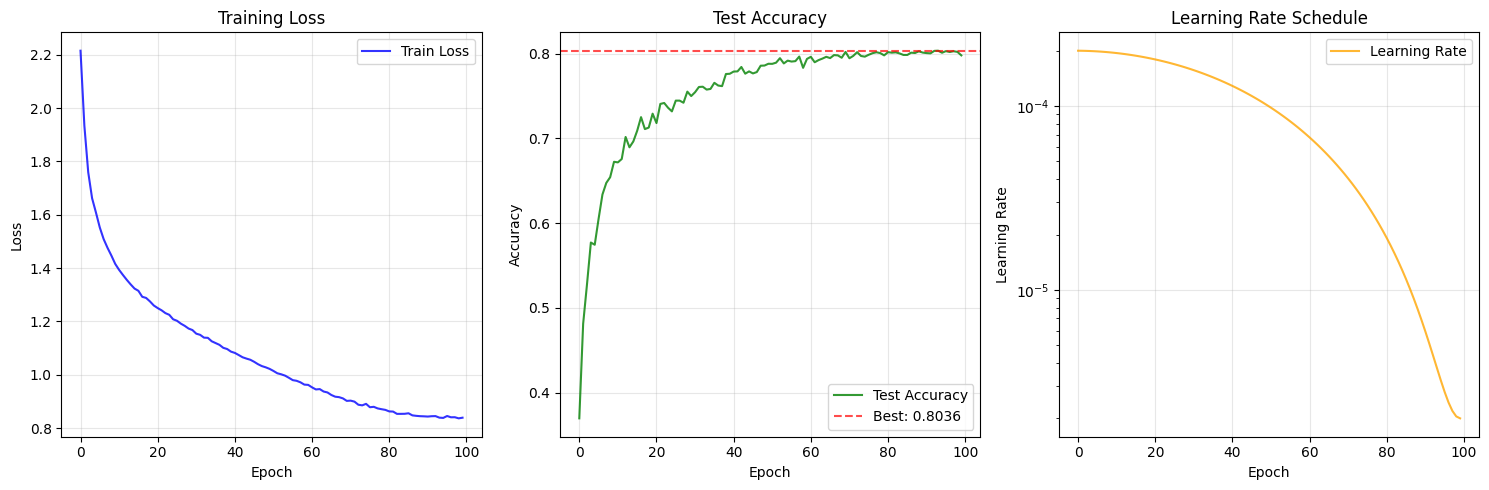


TRAINING SUMMARY
Total Epochs: 100
Best Accuracy: 0.8036
Final Train Loss: 0.8388
Final Test Accuracy: 0.7981
Total Parameters: 11,883,712
Model saved to: ./cifar10_memory_optimized_best.pth

Training completed successfully!
Final Best Accuracy: 0.8036

Running additional analysis...
Testing model inference...
Checkpoint loaded from ./cifar10_memory_optimized_best.pth
Epoch: 94, Best Accuracy: 0.8036
Inference Results (100 samples):
  Average inference time: 13.58 ms
  Accuracy: 0.8300
  Throughput: 73.6 samples/second
Analyzing spiking activity...
Checkpoint loaded from ./cifar10_memory_optimized_best.pth
Epoch: 94, Best Accuracy: 0.8036


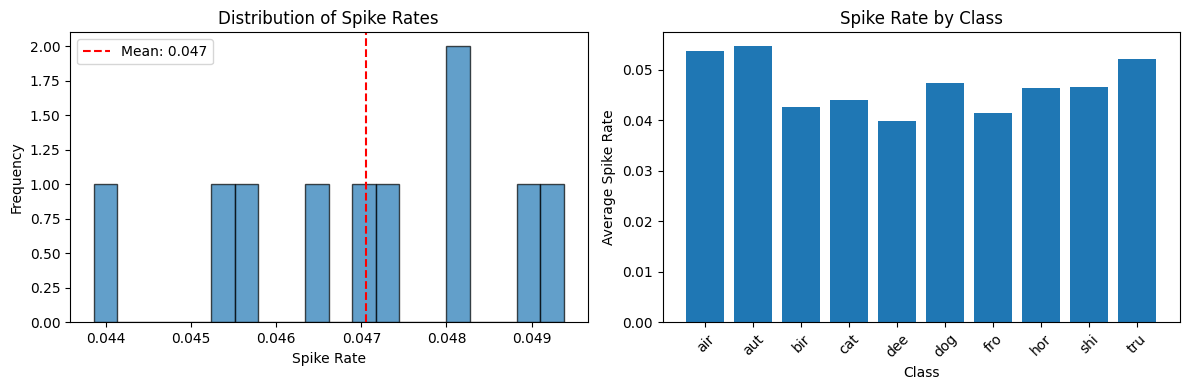

Overall spike statistics:
  Mean spike rate: 0.0471
  Std spike rate: 0.0017
  Min spike rate: 0.0439
  Max spike rate: 0.0494
Memory cleaned up.


In [2]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

"""
Memory-Optimized Temporal Spiking ViT for CIFAR-10
----------------------------------------------------
Key optimizations to reduce memory usage:
- Reduced model dimensions
- Gradient checkpointing
- Mixed precision training
- Smaller batch sizes
- Memory-efficient spiking implementation
"""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, mean_absolute_error, confusion_matrix, roc_curve
import seaborn as sns
import gc

# ================================
# MEMORY-OPTIMIZED HYPERPARAMETERS
# ================================
EMBED_DIM   = 384       # Reduced from 512
NUM_BLOCKS  = 8         # Reduced from 10
NUM_HEADS   = 6         # Reduced from 8
MLP_RATIO   = 3.0       # Reduced from 4.0
PATCH_SIZE  = 4         
T_PATCH     = 4         # Reduced from 8
T_ATTN      = 2         # Reduced from 3
T_MLP       = 2         # Reduced from 3
DROPOUT     = 0.15      
DROPPATH    = 0.15      # Reduced from 0.2
WEIGHT_DECAY= 0.05
LR          = 2e-4      
EPOCHS      = 100       
BATCH_TRAIN = 64        # Reduced from 128
BATCH_TEST  = 128       # Reduced from 256
LABEL_SMOOTH= 0.1       
CLIP_NORM   = 1.0       
WARMUP_EPOCHS = 5       

# Memory optimization flags
USE_GRADIENT_CHECKPOINTING = True
USE_MEMORY_EFFICIENT_ATTENTION = True
ACCUMULATION_STEPS = 2  # Gradient accumulation

COARSE_LOSS_W   = 0.4     
GRAPH_LOSS_W    = 0.15    
KNN_K           = 8       # Reduced from 12
TAU             = 0.07    
BANK_SIZE       = 8192    # Reduced from 16384
GATING_INFER    = True    
EMA_DECAY       = 0.9995  

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    # Memory optimization
    torch.cuda.empty_cache()
    gc.collect()

print(f"Memory-Optimized Spiking ViT for CIFAR-10 initialized on {device}")

# ================================
# Memory-Efficient Spiking Components
# ================================

class MemoryEfficientSurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, temperature=1.0):
        # Use in-place operation where possible
        out = (x >= 0).to(torch.float32)
        # Save only necessary tensors
        ctx.save_for_backward(x, torch.tensor(temperature))
        return out
    
    @staticmethod
    def backward(ctx, grad_out):
        x, temp = ctx.saved_tensors
        alpha = 4.0 / temp.item()
        # Compute gradient efficiently
        sigmoid_x = torch.sigmoid(alpha * x)
        grad = alpha * sigmoid_x * (1 - sigmoid_x)
        return grad_out * grad, None

spike_fn = MemoryEfficientSurrogateSpike.apply

class MemoryEfficientLIFNeuron(nn.Module):
    def __init__(self, decay=0.9, v_th=1.0, learnable=True, temp_scale=1.0):
        super().__init__()
        self.decay = nn.Parameter(torch.tensor(decay)) if learnable else decay
        self.v_th = nn.Parameter(torch.tensor(v_th)) if learnable else v_th
        self.temp_scale = nn.Parameter(torch.tensor(temp_scale)) if learnable else temp_scale
        
    def forward(self, x, T=1):
        if T == 1:
            return spike_fn(x - self.v_th, self.temp_scale)
        
        # Memory-efficient implementation
        spike_sum = torch.zeros_like(x)
        mem = torch.zeros_like(x)
        
        # Process timesteps without storing all spikes
        for t in range(T):
            mem = self.decay * mem + x
            mem = torch.clamp(mem, min=-3*self.v_th, max=4*self.v_th)
            s = spike_fn(mem - self.v_th, self.temp_scale)
            mem = mem * (1 - s)
            
            # Weighted accumulation
            weight = (t + 1) / T  # Simple linear weighting
            spike_sum += weight * s
            
        return spike_sum / (T * (T + 1) / 2)  # Normalize by sum of weights

class OptimizedDropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = x.new_empty(shape).bernoulli_(keep_prob)
        return x * mask / keep_prob

# ================================
# Memory-Efficient Patch Embedding
# ================================

class MemoryEfficientPatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, T=T_PATCH):
        super().__init__()
        self.patch_size = patch_size
        self.T = T
        
        # Single-stage projection to save memory
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.norm = nn.BatchNorm2d(embed_dim)
        self.lif = MemoryEfficientLIFNeuron(decay=0.8, v_th=1.2, learnable=True, temp_scale=0.9)
        
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        
    def forward(self, x):
        feat = self.proj(x)
        feat = self.norm(feat)
        B, C, H, W = feat.shape
        
        # Apply spiking
        spikes = self.lif(feat, T=self.T)
        
        # Convert to tokens
        tokens = spikes.flatten(2).transpose(1, 2)
        
        return tokens, (H, W), spikes

# ================================
# Memory-Efficient Attention
# ================================

class MemoryEfficientAttention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Compute Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Memory-efficient attention
        if USE_MEMORY_EFFICIENT_ATTENTION and N > 256:
            # Process attention in chunks for large sequences
            attn_out = self._chunked_attention(q, k, v)
        else:
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            attn_out = attn @ v
        
        x = attn_out.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x
    
    def _chunked_attention(self, q, k, v, chunk_size=256):
        B, H, N, D = q.shape
        attn_out = torch.zeros_like(v)
        
        for i in range(0, N, chunk_size):
            end_i = min(i + chunk_size, N)
            q_chunk = q[:, :, i:end_i]
            
            attn_chunk = (q_chunk @ k.transpose(-2, -1)) * self.scale
            attn_chunk = attn_chunk.softmax(dim=-1)
            attn_out[:, :, i:end_i] = attn_chunk @ v
            
        return attn_out

# ================================
# Memory-Efficient Transformer Block
# ================================

class MemoryEfficientTransformerBlock(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = MemoryEfficientAttention(embed_dim, num_heads, dropout)
        self.drop1 = OptimizedDropPath(droppath)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Simplified MLP to save memory
        hidden = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, embed_dim),
            nn.Dropout(dropout)
        )
        self.drop2 = OptimizedDropPath(droppath)
        
        # Spiking neurons
        self.snn_attn = MemoryEfficientLIFNeuron(decay=0.75, v_th=0.9, learnable=True, temp_scale=1.1)
        self.snn_mlp = MemoryEfficientLIFNeuron(decay=0.8, v_th=1.0, learnable=True, temp_scale=1.0)
        self.T_attn = T_ATTN
        self.T_mlp = T_MLP
        
    def forward(self, x):
        # Attention block
        y = self.norm1(x)
        y = self.attn(y)
        y = self.snn_attn(y, T=self.T_attn)
        x = x + self.drop1(y)
        
        # MLP block
        y = self.norm2(x)
        y = self.mlp(y)
        y = self.snn_mlp(y, T=self.T_mlp)
        x = x + self.drop2(y)
        
        return x

# ================================
# Main Memory-Optimized Model
# ================================

class MemoryOptimizedSNN_ViT_CIFAR10(nn.Module):
    def __init__(self, num_classes=10, in_channels=3,
                 embed_dim=EMBED_DIM, patch_size=PATCH_SIZE,
                 num_blocks=NUM_BLOCKS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 dropout=DROPOUT, droppath=DROPPATH):
        super().__init__()
        self.num_classes = num_classes
        self.use_checkpoint = USE_GRADIENT_CHECKPOINTING
        
        self.patch = MemoryEfficientPatchEmbed(in_channels, embed_dim, patch_size, T=T_PATCH)
        
        # Simple learnable positional embedding
        num_patches = (32 // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        dpr = [x.item() for x in torch.linspace(0, droppath, num_blocks)]
        self.blocks = nn.ModuleList([
            MemoryEfficientTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, dpr[i])
            for i in range(num_blocks)
        ])
        
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        
        # Simplified heads
        self.head_fine = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, num_classes)
        )
        
        self.head_coarse = nn.Sequential(
            nn.Dropout(dropout * 2),
            nn.Linear(embed_dim, 3)
        )
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward_block(self, x, block):
        return block(x)

    def forward(self, x, return_aux=False):
        tokens, (Hp, Wp), conv_spikes = self.patch(x)
        B, N, C = tokens.shape
        
        # Add CLS token
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, tokens], dim=1)
        
        # Add positional embedding
        x = x + self.pos_embed[:, :N+1]
        x = self.pos_drop(x)
        
        # Process blocks with optional checkpointing
        for block in self.blocks:
            if self.use_checkpoint and self.training:
                x = torch.utils.checkpoint.checkpoint(self.forward_block, x, block, use_reentrant=False)
            else:
                x = block(x)
        
        x = self.norm(x)
        cls_repr = x[:, 0]
        
        # Classification
        fine_logits = self.head_fine(cls_repr)
        coarse_logits = self.head_coarse(cls_repr)
        
        if return_aux:
            aux = {
                "conv_spikes": conv_spikes,
                "cls": cls_repr,
                "coarse_logits": coarse_logits,
                "patch_tokens": x[:, 1:]
            }
            return fine_logits, aux
        return fine_logits, None

# ================================
# Training Utilities (Same as before but memory-optimized)
# ================================

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
COARSE_NAMES = ["transportation", "animals", "mixed"]
PARENT_MAP = {0:0, 1:0, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:0, 9:0}

def build_cifar10_gate_matrix():
    G = torch.zeros(3, 10, dtype=torch.float32)
    for c, p in PARENT_MAP.items():
        G[p, c] = 1.0
    G[2, :] = 0.1
    G = G / G.sum(dim=1, keepdim=True).clamp_min(1e-12)
    return G

class MemoryBank:
    def __init__(self, dim, num_classes, max_size=BANK_SIZE, device="cpu"):
        self.dim = dim
        self.num_classes = num_classes
        self.max_size = max_size
        self.device = device
        self.feats = None
        self.probs = None
        self.insert_idx = 0
        
    def __len__(self):
        return min(self.insert_idx, self.max_size)
    
    @torch.no_grad()
    def add(self, feats, logits):
        if self.feats is None:
            self.feats = torch.zeros(self.max_size, self.dim, device=self.device, dtype=torch.float16)
            self.probs = torch.zeros(self.max_size, self.num_classes, device=self.device, dtype=torch.float16)
        
        feats = F.normalize(feats.detach(), dim=1, p=2).half()
        probs = torch.softmax(logits.detach(), dim=-1).half()
        
        batch_size = feats.size(0)
        for i in range(batch_size):
            idx = self.insert_idx % self.max_size
            self.feats[idx] = feats[i]
            self.probs[idx] = probs[i]
            self.insert_idx += 1
    
    def knn(self, feats, k=KNN_K, tau=TAU):
        if self.__len__() == 0:
            return None, None
            
        feats = F.normalize(feats, dim=1, p=2)
        active_size = min(self.insert_idx, self.max_size)
        active_feats = self.feats[:active_size].float()
        active_probs = self.probs[:active_size].float()
        
        sim = torch.mm(feats, active_feats.t())
        k = min(k, active_size)
        
        vals, idx = sim.topk(k, dim=1)
        w = torch.softmax(vals / tau, dim=1)
        neigh_probs = active_probs[idx]
        
        return w, neigh_probs

def get_cifar10_transforms():
    CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
    CIFAR10_STD = [0.2470, 0.2435, 0.2616]
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])
    
    return transform_train, transform_test

def train_one_epoch_memory_optimized(model, loader, optimizer, scaler, criterion_fine, 
                                    criterion_coarse, bank, epoch, total_epochs):
    model.train()
    total_loss = 0.0
    accumulated_steps = 0
    
    coarse_weight = COARSE_LOSS_W * (1.0 + 0.5 * epoch / total_epochs)
    graph_weight = GRAPH_LOSS_W * min(1.0, epoch / (total_epochs * 0.3))
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        
        with torch.amp.autocast('cuda', enabled=True):
            fine_logits, aux = model(data, return_aux=True)
            cls = aux["cls"]
            coarse_logits = aux["coarse_logits"]
            
            # Losses
            ce_fine = criterion_fine(fine_logits, target)
            coarse_targets = torch.tensor([PARENT_MAP[int(t)] for t in target], device=device)
            ce_coarse = criterion_coarse(coarse_logits, coarse_targets)
            
            # Spike regularization
            conv_spikes = aux.get("conv_spikes", None)
            if conv_spikes is not None:
                spike_rate = conv_spikes.mean()
                target_rate = 0.15 + 0.1 * math.exp(-epoch / 15)
                srl = (spike_rate - target_rate).pow(2) * 2e-3
            else:
                srl = torch.tensor(0.0, device=device)
            
            # Graph loss (simplified)
            if bank is not None and bank.__len__() > 0:
                with torch.no_grad():
                    w, neigh_probs = bank.knn(cls, k=KNN_K, tau=TAU)
                if w is not None:
                    curr_probs = torch.softmax(fine_logits, dim=-1)
                    kl = F.kl_div(curr_probs.log().unsqueeze(1), neigh_probs, reduction='none').sum(dim=-1)
                    g_loss = (w * kl).mean()
                else:
                    g_loss = torch.tensor(0.0, device=device)
            else:
                g_loss = torch.tensor(0.0, device=device)
            
            loss = ce_fine + coarse_weight * ce_coarse + graph_weight * g_loss + srl
            loss = loss / ACCUMULATION_STEPS  # Scale loss for gradient accumulation
        
        scaler.scale(loss).backward()
        accumulated_steps += 1
        
        # Update weights every ACCUMULATION_STEPS
        if accumulated_steps >= ACCUMULATION_STEPS or (batch_idx + 1) == len(loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            accumulated_steps = 0
        
        # Update memory bank
        if bank is not None:
            with torch.no_grad():
                bank.add(cls, fine_logits)
        
        total_loss += loss.item() * ACCUMULATION_STEPS
        
        # Clear cache periodically
        if batch_idx % 50 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(loader)} | Loss: {loss.item() * ACCUMULATION_STEPS:.4f}")
    
    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch}/{total_epochs}] | Avg Loss: {avg_loss:.4f}")
    return avg_loss

@torch.no_grad()
def evaluate_memory_optimized(model, loader, criterion_fine):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        fine_logits, _ = model(data, return_aux=False)
        loss = criterion_fine(fine_logits, target)
        
        pred = fine_logits.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        total_loss += loss.item()
        
    accuracy = correct / total
    avg_loss = total_loss / len(loader)
    
    return accuracy, avg_loss

# ================================
# Detailed Evaluation and Analysis
# ================================

@torch.no_grad()
def detailed_evaluation(model, test_loader):
    """Comprehensive evaluation with metrics and analysis"""
    model.eval()
    
    all_preds = []
    all_targets = []
    all_probs = []
    
    print("Performing detailed evaluation...")
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        fine_logits, aux = model(data, return_aux=True)
        
        probs = torch.softmax(fine_logits, dim=-1)
        preds = fine_logits.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = (all_preds == all_targets).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    # Per-class accuracy
    class_acc = []
    for i in range(10):
        mask = all_targets == i
        if mask.sum() > 0:
            class_acc.append((all_preds[mask] == i).mean())
        else:
            class_acc.append(0.0)
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Display results
    print("\n" + "="*60)
    print("DETAILED EVALUATION RESULTS")
    print("="*60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Macro Precision:  {precision:.4f}")
    print(f"Macro Recall:     {recall:.4f}")
    print(f"Macro F1-Score:   {f1:.4f}")
    
    print("\nPer-Class Accuracy:")
    for i, (class_name, acc) in enumerate(zip(CIFAR10_CLASSES, class_acc)):
        print(f"  {class_name:12s}: {acc:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'class_accuracy': class_acc,
        'confusion_matrix': cm
    }

def visualize_model_analysis(model, test_loader):
    """Visualize model behavior and learned features"""
    model.eval()
    
    # Get a batch for visualization
    data_iter = iter(test_loader)
    data, targets = next(data_iter)
    data, targets = data.to(device), targets.to(device)
    
    with torch.no_grad():
        fine_logits, aux = model(data, return_aux=True)
        conv_spikes = aux["conv_spikes"]
        cls_features = aux["cls"]
        patch_tokens = aux["patch_tokens"]
    
    # Visualize spike activity
    plt.figure(figsize=(15, 10))
    
    # 1. Input images
    plt.subplot(2, 3, 1)
    sample_imgs = data[:8].cpu()
    # Denormalize
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    sample_imgs = sample_imgs * std + mean
    sample_imgs = torch.clamp(sample_imgs, 0, 1)
    
    grid = torch.zeros(3, 32*2 + 5, 32*4 + 15)
    for i in range(8):
        row = i // 4
        col = i % 4
        start_h = row * (32 + 5)
        start_w = col * (32 + 5)
        grid[:, start_h:start_h+32, start_w:start_w+32] = sample_imgs[i]
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.title('Input Images')
    plt.axis('off')
    
    # 2. Spike activity heatmap
    plt.subplot(2, 3, 2)
    spike_mean = conv_spikes[:8].mean(dim=1).cpu()  # Average over channels
    grid_spikes = torch.zeros(8*8 + 7*5, 8*8 + 7*5)
    
    for i in range(8):
        row = i // 2
        col = i % 2
        if i < len(spike_mean):
            start_h = row * (8 + 5)
            start_w = col * (8 + 5)
            grid_spikes[start_h:start_h+8, start_w:start_w+8] = spike_mean[i]
    
    plt.imshow(grid_spikes, cmap='hot')
    plt.title('Spike Activity (Patch Level)')
    plt.colorbar()
    
    # 3. Attention visualization (simplified)
    plt.subplot(2, 3, 3)
    # Use patch token norms as proxy for attention
    patch_norms = torch.norm(patch_tokens[:8], dim=-1).cpu()
    
    grid_attn = torch.zeros(2*8 + 5, 4*8 + 15)
    for i in range(min(8, len(patch_norms))):
        row = i // 4
        col = i % 4
        start_h = row * (8 + 5)
        start_w = col * (8 + 5)
        # Reshape patch norms to 8x8 grid
        patch_grid = patch_norms[i].view(8, 8)
        grid_attn[start_h:start_h+8, start_w:start_w+8] = patch_grid
    
    plt.imshow(grid_attn, cmap='viridis')
    plt.title('Patch Token Importance')
    plt.colorbar()
    
    # 4. Feature distribution
    plt.subplot(2, 3, 4)
    cls_feat_cpu = cls_features[:64].cpu().numpy()
    plt.hist(cls_feat_cpu.flatten(), bins=50, alpha=0.7, density=True)
    plt.title('CLS Token Feature Distribution')
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
    
    # 5. Prediction confidence
    plt.subplot(2, 3, 5)
    probs = torch.softmax(fine_logits[:64], dim=-1)
    max_probs = probs.max(dim=-1)[0].cpu().numpy()
    pred_correct = (fine_logits[:64].argmax(dim=1) == targets[:64]).cpu().numpy()
    
    plt.hist([max_probs[pred_correct], max_probs[~pred_correct]], 
             bins=20, alpha=0.7, label=['Correct', 'Incorrect'], density=True)
    plt.title('Prediction Confidence')
    plt.xlabel('Max Probability')
    plt.ylabel('Density')
    plt.legend()
    
    # 6. Class prediction distribution
    plt.subplot(2, 3, 6)
    pred_classes = fine_logits[:64].argmax(dim=1).cpu().numpy()
    class_counts = np.bincount(pred_classes, minlength=10)
    
    plt.bar(range(10), class_counts)
    plt.title('Predicted Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(10), [c[:3] for c in CIFAR10_CLASSES], rotation=45)
    
    plt.tight_layout()
    plt.show()

def save_model_checkpoint(model, optimizer, epoch, best_acc, loss, filepath):
    """Save comprehensive model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_accuracy': best_acc,
        'loss': loss,
        'hyperparameters': {
            'embed_dim': EMBED_DIM,
            'num_blocks': NUM_BLOCKS,
            'num_heads': NUM_HEADS,
            'mlp_ratio': MLP_RATIO,
            'patch_size': PATCH_SIZE,
            'dropout': DROPOUT,
            'droppath': DROPPATH,
            'batch_size': BATCH_TRAIN,
            'learning_rate': LR,
            'weight_decay': WEIGHT_DECAY,
        },
        'config': {
            'T_PATCH': T_PATCH,
            'T_ATTN': T_ATTN,
            'T_MLP': T_MLP,
            'use_checkpointing': USE_GRADIENT_CHECKPOINTING,
            'accumulation_steps': ACCUMULATION_STEPS,
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to {filepath}")

def load_model_checkpoint(filepath, model, optimizer=None):
    """Load model checkpoint"""
    checkpoint = torch.load(filepath, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_accuracy']
    
    print(f"Checkpoint loaded from {filepath}")
    print(f"Epoch: {epoch}, Best Accuracy: {best_acc:.4f}")
    
    return epoch, best_acc

# ================================
# Main Training Function (Complete)
# ================================

def main_cifar10_memory_optimized():
    print("Memory-Optimized Temporal Spiking ViT for CIFAR-10")
    print(f"Device: {device}")
    
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print(f"GPU Name: {torch.cuda.get_device_properties(0).name}")
    
    print(f"\nOptimized Configuration:")
    print(f"  Embed Dim: {EMBED_DIM} (reduced)")
    print(f"  Blocks: {NUM_BLOCKS} (reduced)")
    print(f"  Heads: {NUM_HEADS} (reduced)")
    print(f"  Batch Size: {BATCH_TRAIN} (reduced)")
    print(f"  Gradient Accumulation: {ACCUMULATION_STEPS} steps")
    print(f"  Gradient Checkpointing: {USE_GRADIENT_CHECKPOINTING}")
    
    # Data loading
    transform_train, transform_test = get_cifar10_transforms()
    
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True, 
                             pin_memory=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=False, 
                            pin_memory=True, num_workers=2)
    
    print(f"\nDataset: {len(train_dataset)} train, {len(test_dataset)} test samples")
    
    # Model
    model = MemoryOptimizedSNN_ViT_CIFAR10(
        num_classes=10,
        in_channels=3,
        embed_dim=EMBED_DIM,
        patch_size=PATCH_SIZE,
        num_blocks=NUM_BLOCKS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        dropout=DROPOUT,
        droppath=DROPPATH,
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} (trainable: {trainable_params:,})")
    
    # Training setup
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion_fine = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
    criterion_coarse = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH * 0.5)
    scaler = torch.amp.GradScaler('cuda', enabled=True)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR * 0.01)
    
    bank = MemoryBank(dim=EMBED_DIM, num_classes=10, max_size=BANK_SIZE, device=device)
    
    # Training loop
    best_acc = 0.0
    train_losses = []
    test_accs = []
    learning_rates = []
    
    print("\nStarting Training...")
    print("=" * 60)
    
    for epoch in range(1, EPOCHS + 1):
        # Clear cache at start of epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
        
        # Train
        train_loss = train_one_epoch_memory_optimized(
            model, train_loader, optimizer, scaler, 
            criterion_fine, criterion_coarse, bank, epoch, EPOCHS
        )
        train_losses.append(train_loss)
        
        # Evaluate
        test_acc, test_loss = evaluate_memory_optimized(model, test_loader, criterion_fine)
        test_accs.append(test_acc)
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch [{epoch}/{EPOCHS}] | Test Acc: {test_acc:.4f} | Best: {best_acc:.4f} | LR: {current_lr:.2e}")
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            save_model_checkpoint(model, optimizer, epoch, best_acc, train_loss, 
                                './cifar10_memory_optimized_best.pth')
            print(f"  → New best model saved! (acc: {best_acc:.4f})")
        
        # Save regular checkpoints
        if epoch % 20 == 0:
            save_model_checkpoint(model, optimizer, epoch, best_acc, train_loss, 
                                f'./cifar10_checkpoint_epoch_{epoch}.pth')
        
        # Early stopping check
        if epoch > 50 and len(test_accs) > 10:
            recent_accs = test_accs[-10:]
            if max(recent_accs) - min(recent_accs) < 0.001:  # Very small improvement
                print(f"Early stopping triggered at epoch {epoch}")
                break
        
        print()
    
    print("=" * 60)
    print(f"Training Complete!")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    
    # Final evaluation
    print("\nPerforming detailed evaluation...")
    try:
        # Load best model
        load_model_checkpoint('./cifar10_memory_optimized_best.pth', model)
        
        # Detailed evaluation
        eval_results = detailed_evaluation(model, test_loader)
        
        # Visualize model analysis
        print("\nGenerating model analysis visualizations...")
        visualize_model_analysis(model, test_loader)
        
    except Exception as e:
        print(f"Error during detailed evaluation: {e}")
    
    # Plot training results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(test_accs, label='Test Accuracy', color='green', alpha=0.8)
    plt.axhline(y=best_acc, color='red', linestyle='--', alpha=0.7, label=f'Best: {best_acc:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(learning_rates, label='Learning Rate', color='orange', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print final summary
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Epochs: {len(train_losses)}")
    print(f"Best Accuracy: {best_acc:.4f}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accs[-1]:.4f}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Model saved to: ./cifar10_memory_optimized_best.pth")
    
    return model, best_acc, {
        'train_losses': train_losses,
        'test_accs': test_accs,
        'learning_rates': learning_rates,
        'best_acc': best_acc
    }

# ================================
# Additional Utility Functions
# ================================

def test_model_inference(model_path='./cifar10_memory_optimized_best.pth'):
    """Test model inference speed and accuracy"""
    print("Testing model inference...")
    
    # Load model
    model = MemoryOptimizedSNN_ViT_CIFAR10().to(device)
    load_model_checkpoint(model_path, model)
    model.eval()
    
    # Load test data
    _, transform_test = get_cifar10_transforms()
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Test inference speed
    import time
    
    times = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 100:  # Test first 100 samples
                break
                
            data, target = data.to(device), target.to(device)
            
            start_time = time.time()
            logits, _ = model(data, return_aux=False)
            end_time = time.time()
            
            times.append(end_time - start_time)
            pred = logits.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += 1
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    accuracy = correct / total
    
    print(f"Inference Results (100 samples):")
    print(f"  Average inference time: {avg_time:.2f} ms")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Throughput: {1000/avg_time:.1f} samples/second")

def analyze_spiking_activity(model_path='./cifar10_memory_optimized_best.pth'):
    """Analyze spiking neural activity"""
    print("Analyzing spiking activity...")
    
    model = MemoryOptimizedSNN_ViT_CIFAR10().to(device)
    load_model_checkpoint(model_path, model)
    model.eval()
    
    _, transform_test = get_cifar10_transforms()
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    spike_rates = []
    class_spikes = {i: [] for i in range(10)}
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= 10:  # Analyze first 10 batches
                break
                
            data, target = data.to(device), target.to(device)
            _, aux = model(data, return_aux=True)
            
            conv_spikes = aux["conv_spikes"]
            spike_rate = conv_spikes.mean().item()
            spike_rates.append(spike_rate)
            
            # Per-class spike analysis
            for j, class_idx in enumerate(target.cpu().numpy()):
                if j < conv_spikes.size(0):
                    class_spike_rate = conv_spikes[j].mean().item()
                    class_spikes[class_idx].append(class_spike_rate)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(spike_rates, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Spike Rate')
    plt.ylabel('Frequency')
    plt.title('Distribution of Spike Rates')
    plt.axvline(np.mean(spike_rates), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spike_rates):.3f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    class_means = [np.mean(rates) if rates else 0 for rates in class_spikes.values()]
    plt.bar(range(10), class_means)
    plt.xlabel('Class')
    plt.ylabel('Average Spike Rate')
    plt.title('Spike Rate by Class')
    plt.xticks(range(10), [c[:3] for c in CIFAR10_CLASSES], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Overall spike statistics:")
    print(f"  Mean spike rate: {np.mean(spike_rates):.4f}")
    print(f"  Std spike rate: {np.std(spike_rates):.4f}")
    print(f"  Min spike rate: {np.min(spike_rates):.4f}")
    print(f"  Max spike rate: {np.max(spike_rates):.4f}")

# ================================
# MAIN EXECUTION
# ================================

if __name__ == "__main__":
    # Set up proper error handling
    try:
        # Run main training
        model, best_acc, results = main_cifar10_memory_optimized()
        
        print(f"\nTraining completed successfully!")
        print(f"Final Best Accuracy: {best_acc:.4f}")
        
        # Optional: Run additional analysis
        print("\nRunning additional analysis...")
        test_model_inference()
        analyze_spiking_activity()
        
    except KeyboardInterrupt:
        print("\nTraining interrupted by user.")
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Clean up
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print("Memory cleaned up.")